## Overview:  
This capstone project is your opportunity to demonstrate the knowledge and abilities you have acquired throughout the course.
This Capstone Project requires learners to work with the following technologies to manage an ETL process for a Loan Application dataset and a Credit Card dataset: Python (Pandas, advanced modules e.g., Matplotlib), MariaDB, Apache Spark (Spark Core, Spark SQL), and Python Visualization and Analytics libraries. Learners are expected to set up their environments and perform installations on their local machines. 


![My Image](workflow.jpg)

In [39]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType,TimestampType,StructField,StructType
from datetime import datetime
import pyspark.sql.functions as F
from pyspark.sql.functions import  concat_ws, regexp_replace, concat,lit,col,udf, lpad,when, length,expr,substring
import re
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import configparser
import pyinputplus as pyip

import findspark
findspark.init()
from pyspark.sql import functions

In [4]:
#masked sensitive data using a config.ini file. Pass the name as value whenever it is needed example , user=user OR password = password

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DATABASE']['host']
user = config['DATABASE']['user']
password = config['DATABASE']['password']
database = config['DATABASE']['database']

In [5]:
spark = SparkSession.builder.appName("CreditCardSystem").getOrCreate()


In [44]:
branch_df=spark.read.json("cdw_sapp_branch.json")
creditcard_df=spark.read.json("cdw_sapp_credit.json")
customer_df=spark.read.json("cdw_sapp_custmer.json")


In [38]:
spark.stop()

### Transform Customer Data frame

In [6]:
# add area code 555 as the first 3 characters for customer phone number, so we can  convert cust_phone column into this format (XXX)XXX-XXXX later
customer_df = customer_df.withColumn("CUST_PHONE", concat(lit("555"), customer_df["CUST_PHONE"]))

In [7]:
customer_df = customer_df.withColumn("cust_phone", 
                   expr("concat('(', substring(cust_phone, 1, 3), ')',  " 
                        "substring(cust_phone, 4, 3), '-', "
                        "substring(cust_phone, 7, 4))").cast("string"))
 
customer_df = customer_df.withColumn("FIRST_NAME", F.initcap("FIRST_NAME").cast("string"))
customer_df = customer_df.withColumn("SSN", customer_df["SSN"].cast("int"))
customer_df = customer_df.withColumn("MIDDLE_NAME", F.lower(customer_df["MIDDLE_NAME"]).cast("string"))
customer_df = customer_df.withColumn("LAST_NAME", F.initcap(customer_df["LAST_NAME"]).cast("string"))
customer_df = customer_df.withColumn("FULL_STREET_ADDRESS", F.concat_ws(", ", customer_df["APT_NO"],customer_df["STREET_NAME"]).cast("string"))
customer_df = customer_df.withColumn("CREDIT_CARD_NO", customer_df["CREDIT_CARD_NO"].cast("string"))
customer_df = customer_df.withColumn("CUST_CITY", customer_df["CUST_CITY"].cast("string"))
customer_df = customer_df.withColumn("CUST_STATE", customer_df["CUST_STATE"].cast("string"))
customer_df = customer_df.withColumn("CUST_COUNTRY", customer_df["CUST_COUNTRY"].cast("string"))
customer_df = customer_df.withColumn("CUST_ZIP", customer_df["CUST_ZIP"].cast("int"))

 
#customer_df = customer_df.withColumn("CUST_PHONE", F.regexp_replace(customer_df["CUST_PHONE"], r'^(\d{3})(\d{3})(\d{4})$', r'(\1)\2-\3').cast("string"))
customer_df = customer_df.withColumn("CUST_EMAIL", customer_df["CUST_EMAIL"].cast("string"))
customer_df = customer_df.withColumn("LAST_UPDATED", customer_df["LAST_UPDATED"].cast("timestamp"))

customer_df=customer_df.select("SSN", "FIRST_NAME","MIDDLE_NAME","LAST_NAME","CREDIT_CARD_NO","FULL_STREET_ADDRESS","CUST_CITY", "CUST_STATE","CUST_COUNTRY","CUST_ZIP","CUST_PHONE","CUST_EMAIL","LAST_UPDATED")

In [11]:
customer_df.printSchema()

root
 |-- SSN: integer (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- FULL_STREET_ADDRESS: string (nullable = false)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_ZIP: integer (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



In [8]:
customer_df.describe().show()

+-------+--------------------+----------+-----------+---------+--------------------+-------------------+---------+----------+-------------+------------------+-------------+--------------------+
|summary|                 SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|      CREDIT_CARD_NO|FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|          CUST_ZIP|   CUST_PHONE|          CUST_EMAIL|
+-------+--------------------+----------+-----------+---------+--------------------+-------------------+---------+----------+-------------+------------------+-------------+--------------------+
|  count|                 952|       952|        952|      952|                 952|                952|      952|       952|          952|               952|          952|                 952|
|   mean|1.2345552588130252E8|      null|       null|     null|4.210653353718597...|               null|     null|      null|         null|36312.616596638654|         null|                null|
| stddev|  2561.1858044909427|

In [8]:
customer_df.show(5)


+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|      SSN|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO| FULL_STREET_ADDRESS|   CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|         CUST_EMAIL|       LAST_UPDATED|
+---------+----------+-----------+---------+----------------+--------------------+------------+----------+-------------+--------+-------------+-------------------+-------------------+
|123456100|      Alec|         wm|   Hooper|4210653310061055|656, Main Street ...|     Natchez|        MS|United States|   39120|(555)123-7818|AHooper@example.com|2018-04-21 12:49:02|
|123453023|      Etta|    brendan|   Holman|4210653310102868|  829, Redwood Drive|Wethersfield|        CT|United States|    6109|(555)123-8933|EHolman@example.com|2018-04-21 12:49:02|
|123454487|    Wilber|   ezequiel|   Dunham|4210653310116272|683, 12th Street ..

### transform branch data frame

In [8]:
# Convert column data types


branch_df = branch_df.withColumn("BRANCH_PHONE", 
                   expr("concat('(', substring(BRANCH_PHONE, 1, 3), ')',  " 
                        "substring(BRANCH_PHONE, 4, 3), '-', "
                        "substring(BRANCH_PHONE, 7, 4))").cast("string"))

branch_df = branch_df.withColumn("BRANCH_CODE", branch_df["BRANCH_CODE"].cast("int"))
branch_df = branch_df.withColumn("BRANCH_NAME", branch_df["BRANCH_NAME"].cast("string"))
branch_df = branch_df.withColumn("BRANCH_STREET", branch_df["BRANCH_STREET"].cast("string"))
branch_df = branch_df.withColumn("BRANCH_CITY", branch_df["BRANCH_CITY"].cast("string"))
branch_df = branch_df.withColumn("BRANCH_STATE", branch_df["BRANCH_STATE"].cast("string"))
branch_df = branch_df.withColumn("BRANCH_ZIP", F.when(branch_df["BRANCH_ZIP"].isNull(), 99999).otherwise(branch_df["BRANCH_ZIP"].cast("int")))
#branch_df = branch_df.withColumn("BRANCH_PHONE", F.regexp_replace(branch_df["BRANCH_PHONE"], r"^(\d{3})(\d{3})(\d{4})$", r"(\1)\2-\3"))
branch_df = branch_df.withColumn("LAST_UPDATED", branch_df["LAST_UPDATED"].cast("timestamp"))

# Select columns 
branch_df = branch_df.select("BRANCH_CODE", "BRANCH_NAME", "BRANCH_STREET", "BRANCH_CITY", "BRANCH_STATE", "BRANCH_ZIP", "BRANCH_PHONE", "LAST_UPDATED")

In [11]:
branch_df.printSchema()

root
 |-- BRANCH_CODE: integer (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_ZIP: integer (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)



In [12]:
branch_df.describe().show()

+-------+-----------------+------------+-------------+-----------+------------+------------------+-------------+
|summary|      BRANCH_CODE| BRANCH_NAME|BRANCH_STREET|BRANCH_CITY|BRANCH_STATE|        BRANCH_ZIP| BRANCH_PHONE|
+-------+-----------------+------------+-------------+-----------+------------+------------------+-------------+
|  count|              115|         115|          115|        115|         115|               115|          115|
|   mean|76.67826086956522|        null|         null|       null|        null|  38975.2347826087|         null|
| stddev|52.94113709535237|        null|         null|       null|        null|23938.156819564818|         null|
|    min|                1|Example Bank|  11th Street|    Acworth|          AL|              2155|(123)410-5725|
|    max|              197|Example Bank|  York Street|   YubaCity|          WI|             98908|(123)498-5926|
+-------+-----------------+------------+-------------+-----------+------------+-----------------

In [13]:
branch_df.show(5)

+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|BRANCH_CODE| BRANCH_NAME|    BRANCH_STREET|      BRANCH_CITY|BRANCH_STATE|BRANCH_ZIP| BRANCH_PHONE|       LAST_UPDATED|
+-----------+------------+-----------------+-----------------+------------+----------+-------------+-------------------+
|          1|Example Bank|     Bridle Court|        Lakeville|          MN|     55044|(123)456-5276|2018-04-18 16:51:47|
|          2|Example Bank|Washington Street|          Huntley|          IL|     60142|(123)461-8993|2018-04-18 16:51:47|
|          3|Example Bank|    Warren Street|SouthRichmondHill|          NY|     11419|(123)498-5926|2018-04-18 16:51:47|
|          4|Example Bank| Cleveland Street|       Middleburg|          FL|     32068|(123)466-3064|2018-04-18 16:51:47|
|          5|Example Bank|      14th Street|    KingOfPrussia|          PA|     19406|(123)484-9701|2018-04-18 16:51:47|
+-----------+------------+------

### TRANSFORM CREDIT CARD DATA 

In [9]:
# Convert DAY, MONTH and YEAR into date format and create new column TIMEID with YYYYMMDD format
creditcard_df = creditcard_df.withColumn('TIMEID', concat(creditcard_df.YEAR, lpad(creditcard_df.MONTH, 2, '0'), lpad(creditcard_df.DAY, 2, '0')).cast('int'))


In [11]:
 


# Rename CREDIT_CARD_NO column as per the mapping document
creditcard_df = creditcard_df.withColumnRenamed('CREDIT_CARD_NO', 'CUST_CC_NO') 

# Convert datatype of columns as per the mapping document
creditcard_df = creditcard_df.withColumn('CUST_CC_NO', creditcard_df['CUST_CC_NO'].cast('string')) 
creditcard_df = creditcard_df.withColumn('CUST_SSN', creditcard_df['CUST_SSN'].cast('int')) 
creditcard_df = creditcard_df.withColumn('BRANCH_CODE', creditcard_df['BRANCH_CODE'].cast('int')) 
creditcard_df = creditcard_df.withColumn('TRANSACTION_TYPE', creditcard_df['TRANSACTION_TYPE'].cast('string')) 
creditcard_df = creditcard_df.withColumn('TRANSACTION_VALUE', creditcard_df['TRANSACTION_VALUE'].cast('double')) 
creditcard_df = creditcard_df.withColumn('TRANSACTION_ID', creditcard_df['TRANSACTION_ID'].cast('int')) 
creditcard_df = creditcard_df.withColumn('TIMEID', creditcard_df['TIMEID'].cast('string'))
creditcard_df=creditcard_df.select("CUST_CC_NO","TIMEID","CUST_SSN","BRANCH_CODE","TRANSACTION_TYPE","TRANSACTION_VALUE","TRANSACTION_ID")
 


In [16]:
creditcard_df.printSchema()

root
 |-- CUST_CC_NO: string (nullable = true)
 |-- TIMEID: string (nullable = true)
 |-- CUST_SSN: integer (nullable = true)
 |-- BRANCH_CODE: integer (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)



In [12]:
creditcard_df.show(10)

+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|  TIMEID| CUST_SSN|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+---------+-----------+----------------+-----------------+--------------+
|4210653349028689|20180214|123459988|        114|       Education|             78.9|             1|
|4210653349028689|20180320|123459988|         35|   Entertainment|            14.24|             2|
|4210653349028689|20180708|123459988|        160|         Grocery|             56.7|             3|
|4210653349028689|20180419|123459988|        114|   Entertainment|            59.73|             4|
|4210653349028689|20181010|123459988|         93|             Gas|             3.59|             5|
|4210653349028689|20180528|123459988|        164|       Education|             6.89|             6|
|4210653349028689|20180519|123459988|        119|   Entertainment|            43.39|             7|


In [18]:
creditcard_df.describe().show()

+-------+--------------------+------------------+-------------------+------------------+----------------+------------------+------------------+
|summary|          CUST_CC_NO|            TIMEID|           CUST_SSN|       BRANCH_CODE|TRANSACTION_TYPE| TRANSACTION_VALUE|    TRANSACTION_ID|
+-------+--------------------+------------------+-------------------+------------------+----------------+------------------+------------------+
|  count|               46694|             46694|              46694|             46694|           46694|             46694|             46694|
|   mean|4.210653353368964E15|2.01806661949501E7|1.234555184812824E8| 75.00057823274939|            null| 51.03938214759932|           23347.5|
| stddev|2.5604641248039957E7|345.41894155270205| 2561.2609103365367|51.389074910957895|            null|28.783264046884938|13479.541071564714|
|    min|    4210653310061055|          20180101|          123451007|                 1|           Bills|              1.01|            

### Load data into Database

In [15]:
# Connect to MariaDB server and create database. If exist it will throw an error 
try:
    cnx = mysql.connector.connect(user=user, password=password,
                              host=host)

    # Create database
    cursor = cnx.cursor()
    DB_NAME = 'creditcard_capstone'
    cursor.execute("CREATE DATABASE {} DEFAULT CHARACTER SET 'utf8'".format(DB_NAME))
    
except mysql.connector.Error as err:
    print("Error connecting to MariaDB: {}".format(err))
    exit()

Error connecting to MariaDB: 1007 (HY000): Can't create database 'creditcard_capstone'; database exists


: 

In [12]:
# establish a Connect to mariadb to createe tables

try:
    cnx = mysql.connector.connect(user=user, password=password,
                              host=host,
                              database=database)
    cursor = cnx.cursor()

except mysql.connector.Error as err:
    print("Error connecting to MariaDB: {}".format(err))
    exit()

In [13]:
try:
    cursor.execute("""CREATE TABLE IF NOT EXISTS CDW_SAPP_BRANCH (
        BRANCH_CODE INT PRIMARY KEY, 
        BRANCH_NAME VARCHAR(50) NOT NULL, 
        BRANCH_STREET VARCHAR(100) NOT NULL, 
        BRANCH_CITY VARCHAR(50) NOT NULL, 
        BRANCH_STATE VARCHAR(50) NOT NULL, 
        BRANCH_ZIP INT NOT NULL, 
        BRANCH_PHONE VARCHAR(20) NOT NULL, 
        LAST_UPDATED TIMESTAMP NOT NULL)""")
    
    cursor.execute("""CREATE TABLE IF NOT EXISTS CDW_SAPP_CREDIT_CARD (
        CUST_CC_NO VARCHAR(50) PRIMARY KEY, 
        TIMEID VARCHAR(8)NOT NULL, 
        CUST_SSN INT NOT NULL, 
        BRANCH_CODE INT NOT NULL, 
        TRANSACTION_TYPE VARCHAR(20) NOT NULL, 
        TRANSACTION_VALUE DOUBLE NOT NULL, 
        TRANSACTION_ID INT NOT NULL)""")
    
    cursor.execute("""CREATE TABLE IF NOT EXISTS CDW_SAPP_CUSTOMER (
        SSN INT PRIMARY KEY, 
        CREDIT_CARD_NO VARCHAR(50) NOT NULL, 
        CUST_FIRST_NAME VARCHAR(50) NOT NULL, 
        CUST_MIDDLE_NAME VARCHAR(50) NOT NULL, 
        CUST_LAST_NAME VARCHAR(50) NOT NULL, 
        CUST_STREET_ADDRESS VARCHAR(100) NOT NULL, 
        CUST_APT_NO VARCHAR(10) NOT NULL, 
        CUST_CITY VARCHAR(50) NOT NULL, 
        CUST_STATE VARCHAR(50) NOT NULL, 
        CUST_COUNTRY VARCHAR(50) NOT NULL, 
        CUST_ZIP INT NOT NULL, 
        CUST_PHONE VARCHAR(10) NOT NULL, 
        CUST_EMAIL VARCHAR(50) NOT NULL, 
        LAST_UPDATED TIMESTAMP NOT NULL)""")
    
except mysql.connector.Error as err:
    print("Error creating tables: {}".format(err))
    exit()


In [14]:
# Load the data into the database tables
try:
    branch_df.write.jdbc(url='jdbc:mysql://localhost:3306/creditcard_capstone', table='CDW_SAPP_BRANCH', mode='overwrite', properties={'user': user, 'password': password})
    creditcard_df.write.jdbc(url='jdbc:mysql://localhost:3306/creditcard_capstone', table='CDW_SAPP_CREDIT_CARD', mode='overwrite', properties={'user': user, 'password': password})
    customer_df.write.jdbc(url='jdbc:mysql://localhost:3306/creditcard_capstone', table='CDW_SAPP_CUSTOMER', mode='overwrite', properties={'user': user, 'password': password})
    cnx.commit() # commit the changes
    
    # Close the database and cursor connection
    cursor.close()
    cnx.close()
except mysql.connector.Error as err:
    print("Error loading data: {}".format(err))
    exit()


### 2. Functional Requirements - Application Front-End

### Once data is loaded into the database, we need a front-end (console) to see/display data. For that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2). 

##### Transaction details menu


Functional Requirements 2.1
1)    Used to display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order.
2)    Used to display the number and total values of transactions for a given type.
3)    Used to display the number and total values of transactions for branches in a given state.



In [54]:
%run transactions_console.py

Transaction Details Menu
1) Display transactions by zip code and date
2) Display number and total value of transactions by type
3) Display number and total value of transactions by branch state
4) Quit
Enter your choice (1-4): 


 ##### Customer Details menu


Functional Requirements 2.2
1) Used to check the existing account details of a customer.
2) Used to modify the existing account details of a customer.
3) Used to generate a monthly bill for a credit card number for a given month and year.
4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.



In [ ]:
%run customer_console.py

 
## 3- Functional Requirements - Data analysis and Visualization
After data is loaded into the database, users can make changes from the front end, and they can also view data from the front end. Now, the business analyst team wants to analyze and visualize the data according to the below requirements.
Use Python libraries for the below requirements:


#### Find and plot which transaction type has a high rate of transactions.

C:\Users\Learner_XZHCG222\AppData\Local\Temp\ipykernel_3212\445889893.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, db)


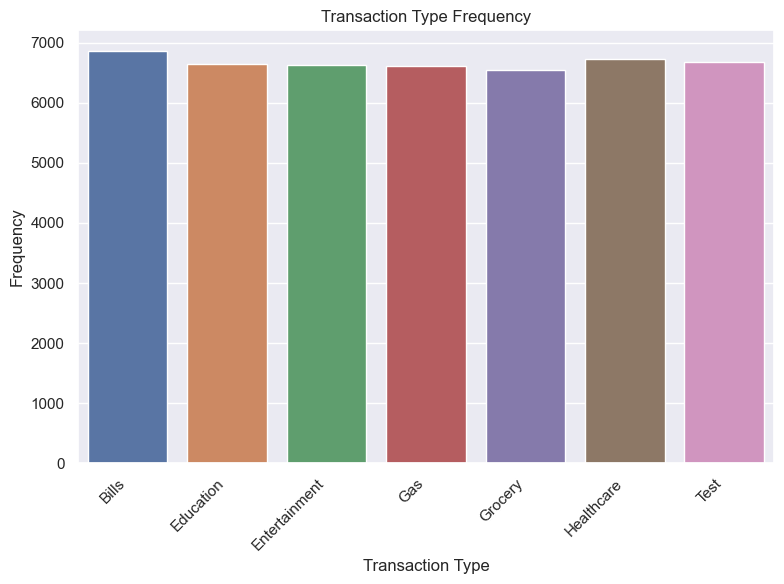

In [48]:
# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)
query = """
SELECT TRANSACTION_TYPE, COUNT(*) AS TRANSACTION_COUNT
FROM CDW_SAPP_CREDIT_CARD
GROUP BY TRANSACTION_TYPE
"""

df = pd.read_sql(query, db)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(8,6)}) # Set the figure size
sns.barplot(x="TRANSACTION_TYPE", y="TRANSACTION_COUNT", data=df)
plt.title("Transaction Type Frequency")
plt.xlabel("Transaction Type")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right') # Rotate the x-axis labels for better visibility
plt.tight_layout() # Fix  overlapping labels or titles
plt.show()

#### Find and plot which state has a high number of customers.

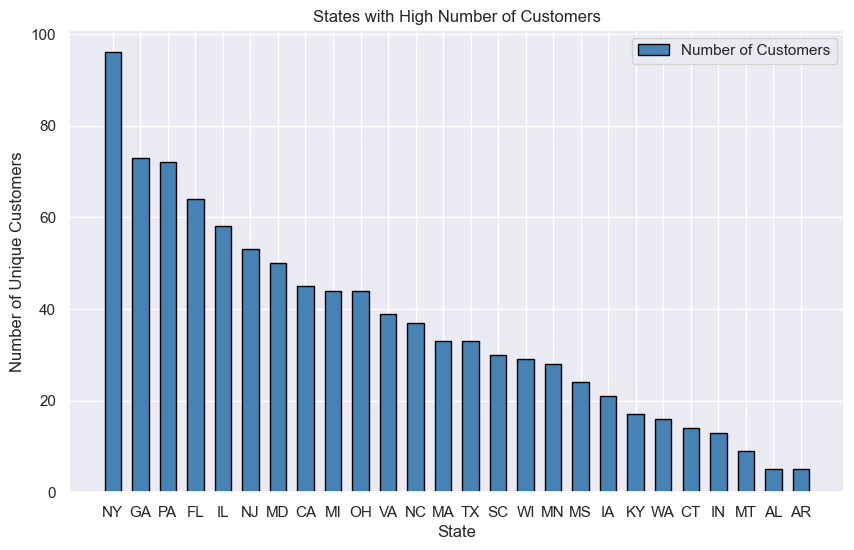

In [50]:

# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database )



# query to count the number of unique customers in each state
cursor = db.cursor()
sql = "SELECT UPPER(CUST_STATE), COUNT(DISTINCT SSN) AS COUNT FROM CDW_SAPP_CUSTOMER \
        GROUP BY UPPER(CUST_STATE) ORDER BY COUNT DESC"
cursor.execute(sql)
result = cursor.fetchall()

# states and their counts into separate lists
states = [row[0] for row in result]
counts = [row[1] for row in result]


fig, ax = plt.subplots(figsize=(10,6))
plt.bar(states, counts,width=0.6, color='steelblue', edgecolor='black')
plt.xlabel('State')
plt.ylabel('Number of Unique Customers')
plt.title('States with High Number of Customers')
plt.legend(['Number of Customers'])
plt.show()


#### Find and plot the sum of all transactions for the top 10 customers, and which customer has the highest transaction amount.
hint(use CUST_SSN). 


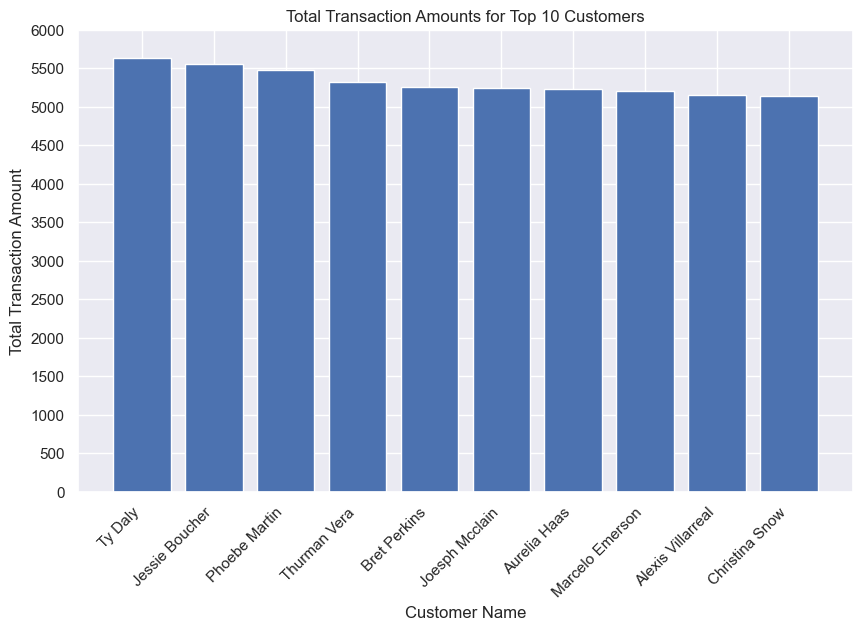

In [44]:
# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# query to get the total transaction amounts for the top 10 customers
cursor = db.cursor()
sql = "SELECT CONCAT(FIRST_NAME, ' ', LAST_NAME) AS NAME, SUM(TRANSACTION_VALUE) AS TOTAL FROM CDW_SAPP_CREDIT_CARD \
        JOIN CDW_SAPP_CUSTOMER ON CDW_SAPP_CREDIT_CARD.CUST_SSN = CDW_SAPP_CUSTOMER.SSN \
            GROUP BY CUST_SSN ORDER BY TOTAL DESC LIMIT 10"

cursor.execute(sql)
result = cursor.fetchall()

# Extracted the customer names and their total transaction amounts into separate lists
customers = [row[0] for row in result]
totals = [row[1] for row in result]

# bar chart showing the total transaction amounts for the top 10 customers
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(customers, totals)
plt.xlabel('Customer Name')
plt.ylabel('Total Transaction Amount')
plt.title('Total Transaction Amounts for Top 10 Customers')
plt.xticks(range(len(customers)), customers, rotation=45, ha='right')
plt.yticks(range(0, int(max(totals))+500, 500))

plt.show()


db.close()




## Overview of LOAN application Data API
Banks deal in all home loans. They have a presence across all urban, semi-urban, and rural areas. Customers first apply for a home loan; after that, a company will validate the customer's eligibility for a loan.
Banks want to automate the loan eligibility process (in real-time) based on customer details provided while filling out the online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History, and others. To automate this process, they have the task of identifying the customer segments to those who are eligible for loan amounts so that they can specifically target these customers. Here they have provided a partial dataset.


API Endpoint: https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json

The above URL allows you to access information about loan application information. This dataset has all of the required fields for a loan application. You can access data from a REST API by sending an HTTP request and processing the response.


In [ ]:

# establish a connection to mariadb

try:
    cnx = mysql.connector.connect(user=user, password=password,
                              host=host,
                              database=database)
    cursor = cnx.cursor()

except mysql.connector.Error as err:
    print("Error connecting to MariaDB: {}".format(err))
    exit()

In [52]:

url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response =requests.get(url)
print(f"The request status code is: {response.status_code}") 

if response.status_code == 200:
    # Read the loan data from the API using Pandas
    loan_data=response.json()
    
     #optional, will get written to DB even without schema. 
     #Realised that spark cast the string values into text hence why i tried doing this   
    loan_df_schema=StructType([
    StructField("Application_ID", StringType(), True),
    StructField("Gender", StringType(), True),
    StructField("Married", StringType(), True),
    StructField("Dependents", StringType(), True),
    StructField("Education", StringType(), True),
    StructField("Self_Employed", StringType(), True),
    StructField("Credit_History", IntegerType() , True),
    StructField("Property_Area", StringType(), True),
    StructField("Income", StringType(), True),
    StructField("Application_Status", StringType(), True)
    ])

    
    # Define Spark DataFrame
    loan_df=spark.createDataFrame(loan_data,schema=loan_df_schema)
    
    # load the Spark DataFrame to the table
    table='cdw_sapp_loan_application'
    loan_df.write \
                    .format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate","true") \
                    .option("url", "jdbc:mysql://localhost:3306/") \
                    .option("dbtable", "creditcard_capstone.{}".format(table)) \
                    .option("truncate","true") \
                    .option("user", user) \
                    .option("characterEncoding","UTF-8") \
                    .option("useUnicode", "true")\
                    .option("password", password).save()
        

    print("Data loaded successfully")
else:
    print("Error: Could not retrieve data. Status code:", response.status_code)
    


The request status code is: 200
Data loaded successfully


#### Plot the percentage of applications approved for self-employed applicants

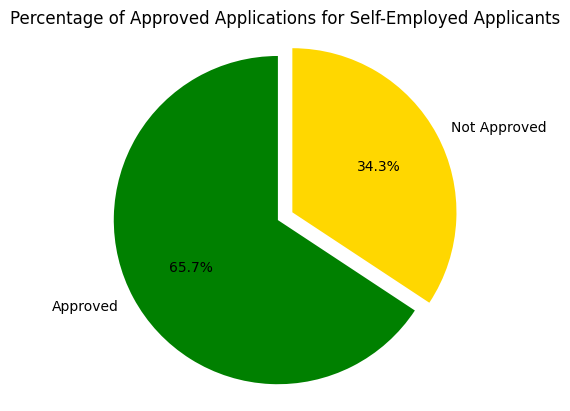

In [65]:
# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

self_employed_df = loan_df.filter(loan_df.Self_Employed == 'Yes')
approved_df = self_employed_df.filter(loan_df.Application_Status == 'Y')
total_count = self_employed_df.count()
approved_count = approved_df.count()


percentage_approved = approved_count/total_count * 100
labels = ['Approved', 'Not Approved']
sizes = [percentage_approved, 100 - percentage_approved]
colors = ['green', 'gold']

plt.pie(sizes, labels=labels,explode=(0.1,0), colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Approved Applications for Self-Employed Applicants')
plt.axis('equal')
plt.show()

In [ ]:
self_employed_df = loan_df.filter(loan_df.Self_Employed == 'Yes')
approved_df = self_employed_df.filter(loan_df.Application_Status == 'Y')
total_count = self_employed_df.count()
approved_count = approved_df.count()
percentage_approved = approved_count/total_count * 100

labels = ['Approved', 'Not Approved']
sizes = [percentage_approved, 100 - percentage_approved]
colors = ['green', 'gold']

fig, ax = plt.subplots()

ax.bar(labels, sizes, color=colors)
ax.set_title('Percentage of Approved Applications for Self-Employed Applicants')
ax.set_ylabel('Percentage')
ax.set_ylim([0, 100])

for i, v in enumerate(sizes):
    ax.text(i, v + 3, str(functions.expr(round(v,1))) + '%', ha='center')

plt.show()

### Plot the percentage of rejection for married male applicants

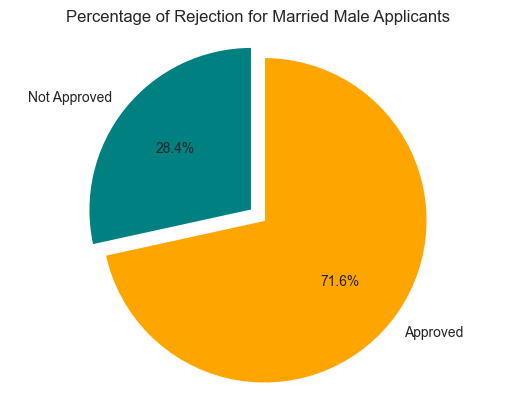

In [75]:

  
rejected_married_male = loan_df.filter((loan_df.Married == "Yes") &
(loan_df.Gender == "Male") &
(loan_df.Application_Status == "N"))

total_applications = loan_df.filter((loan_df.Married == "Yes") &
(loan_df.Gender == "Male")).count()

percentage_rejected = (rejected_married_male.count() / total_applications) * 100
labels = ["Not Approved", "Approved"]
sizes = [percentage_rejected, 100 - percentage_rejected]
colors = ["teal", "orange"]

plt.pie(sizes, labels=labels,explode=(0.1,0), colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Percentage of Rejection for Married Male Applicants")
plt.axis('equal')
plt.show()

#### Find and plot the top three months with the largest transaction data.

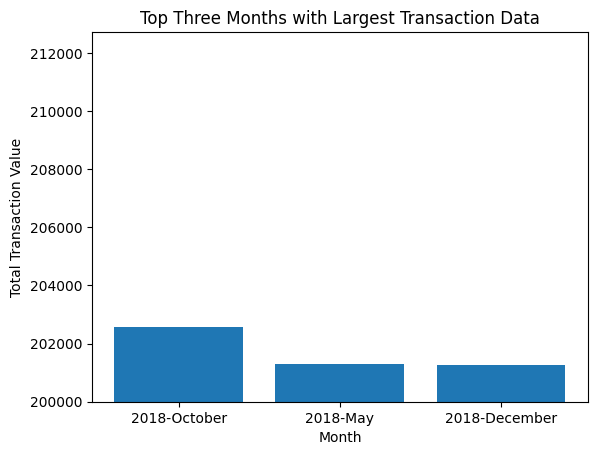

In [55]:
# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)


cursor=db.cursor()

query = "SELECT DATE_FORMAT(timeid,'%Y-%M') as month,SUM(transaction_value) AS Total FROM CDW_SAPP_CREDIT_CARD GROUP BY month ORDER BY Total DESC LIMIT 3"
cursor.execute(query)
data = cursor.fetchall()
x_values = [row[0] for row in data]
y_values = [row[1] for row in data]

plt.bar(x_values, y_values)
plt.xlabel('Month')
plt.ylabel('Total Transaction Value')
plt.title('Top Three Months with Largest Transaction Data')
plt.ylim(bottom=200000)
plt.show()



Find and plot which branch processed the highest total dollar value of healthcare transactions.

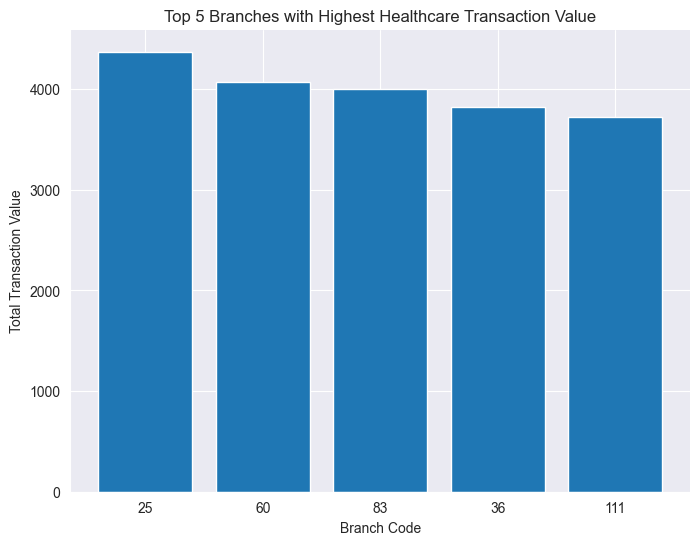

In [82]:
# Connect to the creditcard_capstone database
db = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)
cursor = db.cursor()
query = "SELECT branch_code, SUM(transaction_value) AS Total FROM CDW_SAPP_CREDIT_CARD WHERE TRANSACTION_TYPE = 'HEALTHCARE' GROUP BY branch_code ORDER BY Total DESC LIMIT 5"
cursor.execute(query)
data = cursor.fetchall()

x_values = ([str(row[0]) for row in data])
y_values = [row[1] for row in data]

fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x_values, y_values )
ax.set_xticks(x_values)
ax.set_xticklabels(x_values)
ax.set_xlabel('Branch Code')
ax.set_ylabel('Total Transaction Value')
ax.set_title('Top 5 Branches with Highest Healthcare Transaction Value')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [ ]:
cursor.close()
db.close()
cnx.close()

In [19]:
# Stop SparkSession
spark.stop()